In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from glob import glob
from datasets import load_dataset
from transliterate import translit
import re
from tqdm.auto import tqdm
import mwxml
import wikitextparser as wtp
import json


/home/stef/anaconda3/envs/ocr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
OUTPUT_FILE = "corpus-mk.jsonl"

In [3]:
ASCII_BRACKET_MAP = {
    '{': 'ш',   
    '}': 'ќ',   
    'w': 'њ',   
    '`': 'ж',   
    '~': 'ч',   
    'x': 'џ',  
    'q': 'љ',
    'y': 'ѕ',
    '[': 'Ш',
    }

# --------------------------------------------------------------------------
def bracket_to_latin(text):
    """
    Replace bracket-like ASCII placeholders with 
    approximate Latin forms recognized by the Macedonian translit.
    """
    for ascii_char, latin_replace in ASCII_BRACKET_MAP.items():
        text = text.replace(ascii_char, latin_replace)
    return text

def to_cyrillic(text):
    """
    1) Remove <attachment> tags.
    2) Replace bracket placeholders with Latin digraphs.
    3) Transliterate from (modified) Latin -> Macedonian Cyrillic.
    4) (Optional) remove or normalize punctuation if desired.
    """
    # remove <attachment> tag
    text = re.sub(r'<attachment>', '', text)

    # bracket placeholders -> recognized Latin forms
    text = bracket_to_latin(text)
    text = translit(text, 'mk', reversed=False)
    return text

### Load MMORE datasets

In [4]:
# Example: local directories containing your text files or JSON files
mmore_paths = {
    "merged_results_16673": "../data/mmore/merged_results_16673.jsonl",
    "merged_results_20496": "../data/mmore/merged_results_20496.jsonl",
    "merged_results_23047": "../data/mmore/merged_results_23047.jsonl",
    "merged_results_131075": "../data/mmore/merged_results_131075.jsonl",
    "merged_results_135199": "../data/mmore/merged_results_135199.jsonl",
}

In [5]:
for key, path in mmore_paths.items():
    for chunk in pd.read_json(path, lines=True, chunksize=10000):
        chunk['text'] = chunk['text'].apply(to_cyrillic)
        chunk = chunk[['text']]
        # source 
        chunk['source'] = "MMORE" 
        
        # write to the output file 
        with open(OUTPUT_FILE, 'a') as f:
            for index, row in chunk.iterrows():
                f.write(json.dumps(row.to_dict(), ensure_ascii=False) + '\n')

        print(f"Processed {len(chunk)} rows from {key}")

Processed 103 rows from merged_results_16673
Processed 218 rows from merged_results_20496
Processed 161 rows from merged_results_23047
Processed 3075 rows from merged_results_131075
Processed 1592 rows from merged_results_135199


### Load huggingface datasets (fineweb-2)

In [6]:
fineweb_dataset = load_dataset("HuggingFaceFW/fineweb-2", split='train', name='mkd_Cyrl', streaming=True)
chunk_size = 100000 
chunk = []
total_processed = 0

with open(OUTPUT_FILE, 'a') as f:
    for row in tqdm(fineweb_dataset):
        row['source'] = "fineweb-2"
        # Only keep 'text' and 'source' keys
        row = {k: row[k] for k in ('text', 'source')}
        chunk.append(row)
        
        if len(chunk) >= chunk_size:
            # Serialize the chunk and write to file in one go
            f.write('\n'.join(json.dumps(item, ensure_ascii=False) for item in chunk) + '\n')
            total_processed += len(chunk)
            print(f"Processed {total_processed} rows from fineweb-2")
            chunk = []
    
    # if any remaining rows, write them to file
    if chunk:
        f.write('\n'.join(json.dumps(item, ensure_ascii=False) for item in chunk) + '\n')
        total_processed += len(chunk)
        print(f"Processed {total_processed} rows from fineweb-2")


100655it [01:11, 451.45it/s]

Processed 100000 rows from fineweb-2


201158it [02:19, 909.99it/s] 

Processed 200000 rows from fineweb-2


299501it [03:19, 2797.49it/s]

Processed 300000 rows from fineweb-2


400593it [04:19, 537.75it/s] 

Processed 400000 rows from fineweb-2


499703it [05:10, 4326.67it/s]

Processed 500000 rows from fineweb-2


600761it [06:09, 732.35it/s] 

Processed 600000 rows from fineweb-2


700689it [07:01, 870.94it/s] 

Processed 700000 rows from fineweb-2


800621it [07:53, 901.61it/s] 

Processed 800000 rows from fineweb-2


900997it [08:45, 931.91it/s] 

Processed 900000 rows from fineweb-2


1000948it [09:34, 959.64it/s]

Processed 1000000 rows from fineweb-2


1100661it [10:29, 907.33it/s] 

Processed 1100000 rows from fineweb-2


1200812it [11:14, 926.91it/s] 

Processed 1200000 rows from fineweb-2


1300690it [12:00, 1013.07it/s]

Processed 1300000 rows from fineweb-2


1400988it [12:57, 1036.43it/s]

Processed 1400000 rows from fineweb-2


1500695it [13:58, 945.91it/s] 

Processed 1500000 rows from fineweb-2


1600591it [14:48, 945.31it/s] 

Processed 1600000 rows from fineweb-2


1680868it [15:30, 4082.03it/s]'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 8f6fd339-23c9-40b2-a472-de8e9141f087)')' thrown while requesting GET https://huggingface.co/datasets/HuggingFaceFW/fineweb-2/resolve/e76742d94545d773d1afc8d2fc63442c0347cab4/data/mkd_Cyrl/train/000_00000.parquet
Retrying in 1s [Retry 1/5].
1700943it [15:53, 1026.63it/s]

Processed 1700000 rows from fineweb-2


1800370it [16:44, 759.69it/s] 

Processed 1800000 rows from fineweb-2


1900600it [17:36, 952.42it/s] 

Processed 1900000 rows from fineweb-2


2000710it [18:37, 925.83it/s] 

Processed 2000000 rows from fineweb-2


2100481it [19:49, 755.98it/s] 

Processed 2100000 rows from fineweb-2


2200698it [20:40, 854.80it/s] 

Processed 2200000 rows from fineweb-2


2300595it [21:39, 852.43it/s] 

Processed 2300000 rows from fineweb-2


2400578it [22:43, 537.07it/s] 

Processed 2400000 rows from fineweb-2


2500993it [23:42, 1009.49it/s]

Processed 2500000 rows from fineweb-2


2599762it [24:38, 4878.73it/s]

Processed 2600000 rows from fineweb-2


2699980it [25:31, 4221.55it/s]

Processed 2700000 rows from fineweb-2


2799597it [26:25, 4661.10it/s]

Processed 2800000 rows from fineweb-2


2899622it [27:23, 4054.75it/s]

Processed 2900000 rows from fineweb-2


2999641it [28:12, 3274.98it/s]

Processed 3000000 rows from fineweb-2


3100000it [29:12, 694.92it/s] 

Processed 3100000 rows from fineweb-2


3199559it [30:01, 4752.72it/s]

Processed 3200000 rows from fineweb-2


3299581it [30:57, 4475.27it/s]

Processed 3300000 rows from fineweb-2


3401057it [31:59, 697.07it/s] 

Processed 3400000 rows from fineweb-2


3432720it [32:26, 1600.89it/s]'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 62cd158d-033b-4342-8774-9051997cf953)')' thrown while requesting GET https://huggingface.co/datasets/HuggingFaceFW/fineweb-2/resolve/e76742d94545d773d1afc8d2fc63442c0347cab4/data/mkd_Cyrl/train/000_00000.parquet
Retrying in 1s [Retry 1/5].
3452901it [32:53, 4290.18it/s]'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 830338ce-ec2c-4e3f-b517-7301c226933e)')' thrown while requesting GET https://huggingface.co/datasets/HuggingFaceFW/fineweb-2/resolve/e76742d94545d773d1afc8d2fc63442c0347cab4/data/mkd_Cyrl/train/000_00000.parquet
Retrying in 1s [Retry 1/5].
3500604it [33:41, 784.53it/s] 

Processed 3500000 rows from fineweb-2


3600778it [34:34, 896.51it/s] 

Processed 3600000 rows from fineweb-2


3700935it [35:37, 886.26it/s] 

Processed 3700000 rows from fineweb-2


3800455it [36:44, 449.65it/s] 

Processed 3800000 rows from fineweb-2


3885664it [38:16, 1691.95it/s]


Processed 3885664 rows from fineweb-2


### Load wiki dataset

In [7]:
def clean_wikitext(wikitext):
    parsed = wtp.parse(wikitext)
    for template in parsed.templates:
        wikitext = wikitext.replace(str(template), "")
    parsed = wtp.parse(wikitext)
    return parsed.plain_text()

def extract_pages(dump_file):
    pages = [] 

    with open(dump_file, 'rb') as f:
        dump = mwxml.Dump.from_file(f)
        for i, page in enumerate(dump):
            if page.namespace != 0: 
                continue
            
            for revision in page:
                if revision.text is None:  # Skip pages with no text
                    continue
                
                cleaned_text = clean_wikitext(revision.text)
                page_data = {
                    "text": cleaned_text.strip() 
                }
                pages.append(page_data)
                break  # Only process the latest revision
    return pages

wiki_path = "../data/other/mkwiki-latest-pages-articles-multistream.xml"

cleaned_pages = extract_pages(wiki_path)
print(f"Loaded {len(cleaned_pages)} pages into memory.")
print(cleaned_pages[0])

with open(OUTPUT_FILE, 'a') as f:
    for page in cleaned_pages:
        page['source'] = "mkwiki"
        f.write(json.dumps(page, ensure_ascii=False) + '\n')

print(f"Appended {len(cleaned_pages)} pages from mkwiki to {OUTPUT_FILE}.")

Loaded 204091 pages into memory.
{'text': '__NOTOC____NOEDITSECTION__\n\n\n\n\n\n\n\n\n\n\nслободната енциклопедија што може секој да ја уредуваимаме  статии на македонски јазик\n\n\n\n\n\n\n\n\n{| width="100%"\nИзбрана статија за оваа седмица\n\n\nархива\xa0· наредни избрани статии\xa0· критериуми\n \n\n\nнајгоре  [ превчитај ја страницава] статистики односи со јавноста пријавете неправилност village pump'}
Appended 204091 pages from mkwiki to corpus-mk.jsonl.


### Load SETIMES mk-en only mk part 

In [8]:
with open("../data/other/train.mk", "r") as f:
    setimes_mk = f.readlines()

setimes_mk = [line.strip() for line in setimes_mk]

# append to the output file 
with open(OUTPUT_FILE, 'a') as f:
    for text in setimes_mk:
        row = {"text": text, "source": "setimes-mk"}
        f.write(json.dumps(row, ensure_ascii=False) + '\n')

### Load CLASSLA MaCoCu dataset

<Axes: xlabel='genre'>

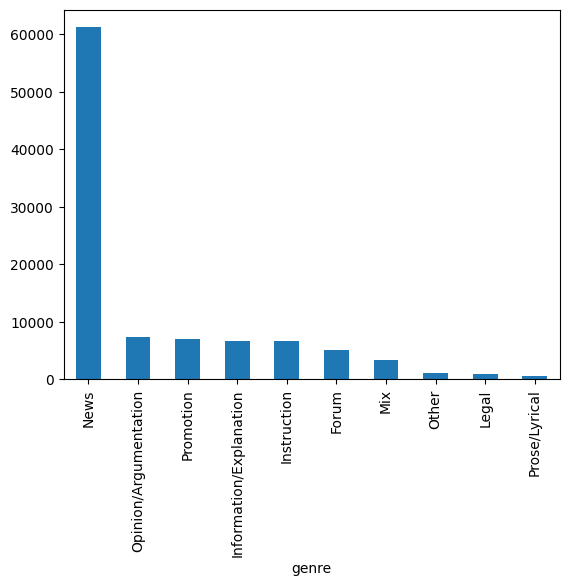

In [9]:
# 16GB
macocu_path = "../data/other/MaCoCu-Genre.mk.jsonl"
macocu = pd.read_json(macocu_path, lines=True, chunksize=100000, encoding='utf-8')

# see a sample of the data
sample = next(macocu)
# plot genre distribution 
sample['genre'].value_counts().plot(kind='bar')
# majority are news, not sure if this is a good representation of the data - we can maybe filter out news articles:), we will see.

In [10]:
chunk_size = 100000
for chunk in pd.read_json(macocu_path, lines=True, chunksize=chunk_size, encoding='utf-8'):
    chunk['source'] = "macocu"
    
    chunk = chunk[['text', 'source']]
    
    with open(OUTPUT_FILE, 'a') as f:
        for _, row in chunk.iterrows():
            f.write(json.dumps(row.to_dict(), ensure_ascii=False) + '\n')
    
    print(f"Processed {len(chunk)} rows from MaCoCu dataset.")

print("Finished processing MaCoCu dataset.")

Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 100000 rows from MaCoCu dataset.
Processed 82495 rows from MaCoCu dataset.
Finished processing MaCoCu dataset.


### Load HPTL MK dataset

In [12]:
# 16GB
hplt_path = "../data/other/HPLT.jsonl"

chunk_size = 1000
for chunk in pd.read_json(hplt_path, lines=True, chunksize=chunk_size, encoding='utf-8'):
    chunk = chunk[['text']]
    chunk['source'] = "hplt"
    
    with open(OUTPUT_FILE, 'a', encoding='utf-8') as f:
        for _, row in chunk.iterrows():
            f.write(json.dumps(row.to_dict(), ensure_ascii=False) + '\n')
    
    print(f"Processed {len(chunk)} rows from HPLT dataset.")

print("Finished processing HPLT dataset.")

Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from HPLT dataset.
Processed 1000 rows from 

### Load common voice dataset 

In [13]:
# 4. common voice 
common_voice_path = "../data/other/common_voice.txt"
with open(common_voice_path, "r") as f:
    common_voice = f.readlines()

# omit the \n from the end
common_voice = [line.strip() for line in common_voice]

with open(OUTPUT_FILE, 'a') as f:
    for text in common_voice:
        row = {"text": text, "source": "common_voice"}
        f.write(json.dumps(row, ensure_ascii=False) + '\n')

### Upload to HuggingFace

In [3]:
## Optional step
## Clean/anonymize the dataset

# import orjson
# from cleantext import clean
# from tqdm import tqdm

# input_file = "corpus-mk.jsonl"
# output_file = "corpus-mk-cleaned.jsonl"

# chunk_size = 1000 

# def process_chunk(lines, outfile):
#     for line in lines:
#         try:
#             row = orjson.loads(line)
#             row['text'] = clean(
#                 row['text'],
#                 fix_unicode=True,
#                 to_ascii=False,
#                 lower=False,
#                 no_line_breaks=False,
#                 no_urls=False,
#                 no_emails=True,
#                 no_phone_numbers=True,
#                 no_numbers=False,
#                 no_digits=False,
#                 no_currency_symbols=False,
#                 no_punct=False,
#                 replace_with_url="[URL]",
#                 replace_with_email="[EMAIL]",
#                 replace_with_phone_number="[PHONE]",
#                 replace_with_number="[NUMBER]",
#                 replace_with_digit="0",
#                 replace_with_currency_symbol="[CURRENCY]",
#                 lang="mk"
#             )
#             outfile.write(orjson.dumps(row).decode('utf-8') + "\n")
#         except orjson.JSONDecodeError:
#             continue
#         except Exception as e:
#             print(f"An error occurred: {e}")
#             continue

# with open(input_file, 'r', encoding='utf-8') as infile, \
#      open(output_file, 'w', encoding='utf-8') as outfile:

#     lines = []
#     for line in tqdm(infile):
#         lines.append(line)
#         if len(lines) == chunk_size:
#             process_chunk(lines, outfile)
#             lines = []  
#     if lines:
#         process_chunk(lines, outfile)

# print("Finished cleaning and anonymizing the dataset.")


0it [00:00, ?it/s]

9543129it [5:45:39, 460.14it/s]  

Finished cleaning and anonymizing the dataset.


In [1]:
# Install the huggingface_hub library if not already installed
# !pip install huggingface_hub

from huggingface_hub import HfApi, login
login(token="token here")
api = HfApi()

repo_id = "LVSTCK/macedonian-corpus-raw"
output_file = "corpus-mk.jsonl.gz"
api.upload_file(
    path_or_fileobj=output_file,  # Path to the file
    path_in_repo="corpus-mk.jsonl.gz",  # Name of the file in the repository
    repo_id=repo_id,  # Repo ID
    repo_type="dataset",  
)

print(f"Uploaded {output_file} to {repo_id}.")

/home/stef/anaconda3/envs/ocr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/stef/.cache/huggingface/token
Login successful


corpus-mk.jsonl.gz: 100%|██████████| 10.5G/10.5G [37:30<00:00, 4.69MB/s]  


Uploaded corpus-mk.jsonl.gz to LVSTCK/macedonian-corpus-raw.


In [ ]:
## Print out some statistics 

import json
import os
from tqdm import tqdm

file_path = "corpus-mk-old.jsonl"
origin_stats = {}

# naive tokenization (maybe should we swapped with spacy mk tokenizer)
def count_tokens(text):
    return len(text.split())

with open(file_path, "r", encoding="utf-8") as file:
    for line in tqdm(file, desc="Processing lines"):
        data = json.loads(line)
        origin = data.get("source", "Unknown")  
        text = data.get("text", "")

        if origin not in origin_stats:
            origin_stats[origin] = {"size": 0, "tokens": 0, "lines": 0}

        line_size = len(line.encode("utf-8"))  # Size in bytes
        token_count = count_tokens(text)

        origin_stats[origin]["size"] += line_size
        origin_stats[origin]["tokens"] += token_count
        origin_stats[origin]["lines"] += 1

total_size = sum(stats["size"] for stats in origin_stats.values())
total_tokens = sum(stats["tokens"] for stats in origin_stats.values())

for origin, stats in origin_stats.items():
    stats["size_gb"] = stats["size"] / (1024 ** 3)  # Size in GB
    stats["percentage"] = (stats["tokens"] / total_tokens) * 100

print(f"{'Origin':<15}{'Size (GB)':<15}{'Tokens':<20}{'Percentage':<15}")
print("=" * 60)
for origin, stats in origin_stats.items():
    print(f"{origin:<15}{stats['size_gb']:<15.2f}{stats['tokens']:<20}{stats['percentage']:<15.2f}")
